In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
!pip install -q einops 

In [38]:
%load_ext autoreload
%autoreload 2

import random
import imageio
import numpy as np
from argparse import ArgumentParser

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt


import einops 
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader


from torchvision import transforms
from torchvision import datasets


#* set reporoducibility 
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
def show_images(images, title=""):
    # *detaching tensors to save ram
    if type(images) is torch.Tensor:
        images = images.detach().cpu().numpy()

    # * containing box
    fig = plt.figure(figsize=(4, 4))
    rows = int(len(images) ** 0.5)
    cols = round(len(images) / rows)
    # print(type(images), len(images))

    # * adjusting subplots
    idx = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, idx + 1)
            
            if idx < len(images):
                #print(images[idx].shape)
                if images[idx].shape[0] == 1:
                    plt.imshow(images[idx][0], cmap="gray")
                else:
                    plt.imshow(images[idx][0].permute(1, 2, 0))
            plt.axis("off")
            idx += 1
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    plt.show()
    
#* show the first batch of images
def show_first_batch(loader):
    for batch in loader :
        show_images(batch[0], title="First batch of images")
        break

In [40]:
## DDPM class - forward pass
class MarkovDDPM(nn.Module):
    def __init__(self, network, n_steps, start, end, device, image_ch=((1, 28, 28))):
        super().__init__()
        
        self.network = network
        self.n_steps = n_steps
        self.start = start
        self.end = end
        self.device = device
        self.image_ch = image_ch
        
        #* define process 
        self.betas = torch.linspace(start, end, n_steps).to(device)
        self.alphas = 1 - self.betas
        #self.alpha_bars = torch.tensor([torch.prod(self.alphas[:i+1]) for i in range(len(self.alphas))]).to(device)
        self.alpha_bars = torch.cumprod(self.alphas, dim=0).to(device)
        
    def forward(self, x0, t, noise=None):
        n_batch, n_ch, n_row, n_col = x0.shape
        # print(t)
        a_bar = self.alpha_bars[t]
        # print(a_bar)
        
        #* generate noise if not given
        if noise is None:
            noise = torch.randn(x0.shape).to(self.device)

        # noisy = img*sqrt(a_bar) + sqrt(1-a_bar)*noise
        noisy = torch.sqrt(a_bar).reshape(-1, 1, 1, 1) * x0 + torch.sqrt(1 - a_bar).reshape(-1, 1, 1, 1) * noise
        
        return noisy
    
    #* for the U-net
    def backward(self, x, t):
        return self.network(x, t)

In [41]:
from typing import List, Tuple, Optional

def show_forward(
    ddpm,
    loader,
    device,
    show_original=True,
    noise_percent: Optional[List[int]] = [0.25, 0.5, 0.75, 1],
):
    # Showing the forward process
    for batch in loader:
        imgs = batch[0]
        if noise_percent is None:
            noise_percent = [0.25, 0.5, 0.75, 1]
        if show_original:
            show_images(imgs, "Original images")

        for percent in (noise_percent if type(noise_percent) is list else [noise_percent]):     
            try:
                images_ = ddpm(imgs.to(device), int(percent * ddpm.n_steps) - 1)
            except:
                print("Wrong noise_percent input")
                print("Percentage has to be a list of floats from 0 to 1 or a float from 0 to 1")
                print('if you are not sure what to do, just use the default value of [0.25, 0.5, 0.75, 1] or pass None')
                break
            show_images(
                # images= ddpm(imgs.to(device),[int(percent * ddpm.n_steps) - 1 for _ in range(len(imgs))]),
                images=images_,
                title=f"DDPM Noisy images {int(percent * 100)}%",
            )
        break


## paramerts

- Eta = Noise
- eta_thera = backprobagated noise

$$
x_t = \frac{1}{\sqrt{\bar{\alpha_t}}} * (x - \frac{1- \alpha_t}{1 - \sqrt{1-\bar{\alpha_t}}} * \eta_t)
$$

$$
x_t = x_t + \sigma_t * random_noise
$$


In [42]:
def generate_new_images(
    ddpm,
    n_sample=16,
    device=None,
    frames_per_gif =100,
    gif_name="ddpm_samping.gif",
    n_c=1,
    img_h=28,
    img_w=28,
):
    #* line space of the steps 
    frames_idx = np.linspace(0, ddpm.n_steps, frames_per_gif ).astype(np.uint8)
    frames = []
    
    with torch.no_grad():
        if device is  None:
            device = ddpm.device
            
        #* generate noise
        x = torch.randn(n_sample, n_c, img_h, img_w).to(device) #* input shape
        
        #* generate images
        for idx, t in enumerate(list(range(ddpm.n_steps))[::-1]): #* reverse order
            #* estimating noise to be removed 
            
            time_tensor = (torch.ones(n_sample, 1) * t).to(device).long() #shape (batch_size, 1)
            
            #* back propogated noise
            eta_theta = ddpm.backward(x, time_tensor) #* shape (batch_size, n_c, img_h, img_w)
            
            alpha_t = ddpm.alphas[t]
            alpha_bar_t = ddpm.alpha_bars[t]
            
            x = (1/ torch.sqrt(alpha_t)) * (x - (1 -  alpha_t)/ (torch.sqrt(1-alpha_bar_t)) * eta_theta) 
            
            if t >0 :
                z = torch.randn(n_sample, n_c, img_h, img_w).to(device)
                beta_t = ddpm.betas[t]
                sigma_t = torch.sqrt(beta_t)
                
                #* applying Langevin Dynamics noise
                x = x + sigma_t * z 
                
                
            ## Creating the gif
            #* adding frames to the gif
            if idx in frames_idx or t == 0:
                normalized = x.clone()
                
                for i in range(len(normalized)):
                    normalized[i] -= torch.min(normalized[i])
                    normalized[i] *= 255 / torch.max(normalized[i])
                    
                #* resahimg to a square image
                frame = einops.rearrange(normalized, "(b1 b2) c h w -> (b1 h) (b2 w) c", b1=int(n_sample ** 0.5))
                frames.append(frame.cpu().numpy().astype(np.uint8))
        
    for i in range(int(len(frames)/5)):
        frames.append(frames[-1])
    #* saving the gif
    imageio.mimsave(gif_name, frames, format = 'GIF-PIL', fps = 90)
    
    # return frames
    #print(type(frames))
    return x




## Building the U-Net

In [43]:
class Block(nn.Module):
    def __init__(
        self,
        shape,
        in_c,
        out_c,
        kernel_size=3,
        stride=1,
        padding=1,
        activation=None,
        normaliza=True,
    ):
        super().__init__()

        self.layer_norm = nn.LayerNorm(shape)  # * normalizing over the channels
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size, stride, padding)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size, stride, padding)
        # * sigmoid linear unit SiLU : x * sigmoid(x)
        self.activation = nn.SiLU() if activation is None else activation
        self.norm = normaliza

    def forward(self, x):
        # * normalizing over the channels if needed
        out = self.layer_norm(x) if self.norm else x
        out = self.conv1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.activation(out)
        return out

## Positonal Embedding

In [44]:
import torch 
import math

class SinsuoidalPostionalEmbedding(torch.nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        
    def forward(self, sequence, device = None):
        """
        equation: 
            - n  =log_2(10000) / (d - 1)
            - d = dim // 2
            - embedding = exp(d * -n) for d = 0, 1, 2, ..., d-1
            - embedding_space = sequence[:, None] * embedding[None, :]
            - sine_embedding = sin(embedding_space)
            - cosine_embedding = cos(embedding_space)
            - embedding = concat(sine_embedding, cosine_embedding)
        """
        #print(device)
        d = self.dim // 2
        n = math.log(10000) / (d - 1 + 1e-8) #* n
        
        #* d^(-n) where d = 0, 1, 2, ..., d-1
        #* tensor of shape (d,)
        embedding = torch.exp(torch.arange(d, device=device) * -n).to(device)
        embedding = sequence[:, None].to(device) * embedding[None, :].to(device) #* (seq_len, d)
        
        #* sin(embedding) and cos(embedding), then concat them
        embedding = torch.cat((embedding.sin(), embedding.cos()), dim=-1) #* (seq_len, 2d)
        embedding = embedding.to(device)
        return embedding

def sinusoidal_embedding(n, d, device = 'cuda'):
    # Returns the standard positional embedding
    embedding = torch.zeros(n, d)
    wk = torch.tensor([1 / 10_000 ** (2 * j / d) for j in range(d)])
    wk = wk.reshape((1, d))
    t = torch.arange(n).reshape((n, 1))
    embedding[:,::2] = torch.sin(t * wk[:,::2])
    embedding[:,1::2] = torch.cos(t * wk[:,::2])
    embedding = embedding.to(device)

    return embedding

    
        

## UNET

In [45]:
from torch import nn
import torch.nn.functional as F

class UNET(nn.Module):
    def __init__(self, n_steps=100, time_emb_dim=100, device="cpu"):
        super().__init__()

        # * sinusoidal positional embedding
        self.time_embed = nn.Embedding(n_steps, time_emb_dim, device=device)
        self.time_embed.weight.data = SinsuoidalPostionalEmbedding(time_emb_dim)(torch.arange(n_steps, device=device), device)
        self.time_embed.requires_grad_(False)

        # * Brain_puler Embedding
        # self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        # self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
        # self.time_embed.requires_grad_(False)

        ################### First Half of the U-net ###################

        ##*part 1
        self.te1 = self._make_te(time_emb_dim, 1)
        # * te1 is the time embedding for the first half of the U-net
        self.block1 = nn.Sequential(
            # *(batch_size, 1, 28, 28) to (batch_size, 10, 28, 28)
            Block(shape=(1, 28, 28), in_c=1, out_c=10),
            Block(shape=(10, 28, 28), in_c=10, out_c=10),
            Block(shape=(10, 28, 28), in_c=10, out_c=10),
        )
        self.down1 = nn.Conv2d(10, 10, 2, 2)
        # * (batch_size, 10, 28, 28) to (batch_size, 10, 14, 14)
        # * try MaxPool2d instead of Conv2d

        ##*part 2
        self.te2 = self._make_te(time_emb_dim, 10)
        # * te2 is the time embedding for the second half of the U-net
        self.block2 = nn.Sequential(
            # * (batch_size, 10, 14, 14) to (batch_size, 20, 14, 14)
            Block(shape=(10, 14, 14), in_c=10, out_c=20),
            Block(shape=(20, 14, 14), in_c=20, out_c=20),
            Block(shape=(20, 14, 14), in_c=20, out_c=20),
        )
        self.down2 = nn.Conv2d(20, 20, 2, 2)
        # * (batch_size, 20, 14, 14) to (batch_size, 20, 7, 7)

        ##* part 3
        self.te3 = self._make_te(time_emb_dim, 20)
        # * te3 is the time embedding for the third half of the U-net
        self.block3 = nn.Sequential(
            # * (batch_size, 20, 7, 7) to (batch_size, 40, 7, 7)
            Block(shape=(20, 7, 7), in_c=20, out_c=40),
            Block(shape=(40, 7, 7), in_c=40, out_c=40),
            Block(shape=(40, 7, 7), in_c=40, out_c=40),
        )

        # * down3 is the last down sampling layer
        # * (batch_size, 40, 7, 7) to (batch_size, 40, 3, 3)
        #! maxpooling won't work here, may be try
        self.down3 = nn.Sequential(
            nn.Conv2d(40, 40, 2, 2),
            nn.SiLU(),
            nn.Conv2d(40, 40, 1, 1),
        )

        ## Bottleneck
        # upsample the image from (batch_size, 40, 3, 3) to (batch_size, 20, 3, 3)

        # * time embedding for the bottleneck
        self.te_mid = self._make_te(time_emb_dim, 40)
        self.bottleneck = nn.Sequential(
            # * (batch_size, 40, 3, 3) to (batch_size, 40, 3, 3)
            Block(shape=(40, 3, 3), in_c=40, out_c=20),
            Block(shape=(20, 3, 3), in_c=20, out_c=20),
            Block(shape=(20, 3, 3), in_c=20, out_c=40),
        )

        ################### Second Half of the U-net ###################

        # * first upsample block
        self.up1 = nn.Sequential(
            # * (batch_size, 20, 3, 3) to (batch_size, 20, 7, 7)
            nn.ConvTranspose2d(
                40, 40, 4, 2, 1
            ),  # kernel_size =4 , stride = 2, padding = 1
            nn.SiLU(),
            nn.ConvTranspose2d(
                40, 40, 2, 1
            ),  # kernel_size = 2, stride = 1, padding = 0
        )

        # * 4th time embedding layer
        self.te4 = self._make_te(time_emb_dim, 80)

        # * feature extraction block, inserted after the first upsample block
        # * to extract features from the skip connection
        # * reduce the number of channels from 80 to 20
        self.block4 = nn.Sequential(
            # * (batch_size, 80, 7, 7) to (batch_size, 20, 7, 7)
            Block(shape=(80, 7, 7), in_c=80, out_c=40),
            Block(shape=(40, 7, 7), in_c=40, out_c=20),
            Block(shape=(20, 7, 7), in_c=20, out_c=20),
        )
        # * second upsample block
        self.up2 = nn.ConvTranspose2d(20, 20, 4, 2, 1)
        # * (batch_size, 20, 7, 7) to (batch_size, 20, 14, 14)

        # * 5th time embedding layer
        self.te5 = self._make_te(time_emb_dim, 40)
        self.b5 = nn.Sequential(
            # * (batch_size, 40, 14, 14) to (batch_size, 10, 14, 14)
            Block(shape=(40, 14, 14), in_c=40, out_c=20),
            Block(shape=(20, 14, 14), in_c=20, out_c=10),
            Block(shape=(10, 14, 14), in_c=10, out_c=10),
        )

        # * third upsample block
        self.up3 = nn.ConvTranspose2d(10, 10, 4, 2, 1)
        # * output time embedding layer
        self.te_out = self._make_te(time_emb_dim, 20)

        # * output block
        self.out_block = nn.Sequential(
            # * (batch_size, 10, 28, 28) to (batch_size, 10, 28, 28)
            Block(shape=(20, 28, 28), in_c=20, out_c=10),
            Block(shape=(10, 28, 28), in_c=10, out_c=10),
            Block(shape=(10, 28, 28), in_c=10, out_c=10, normaliza=False),
        )

        # * output convolution layer
        # * (batch_size, 10, 28, 28) to (batch_size, 1, 28, 28)
        self.conv_out = nn.Conv2d(10, 1, 3, 1, 1)

    def _make_te(self, dim_in, dim_out):
        return nn.Sequential(
            nn.Linear(dim_in, dim_out),
            nn.ReLU(),
            nn.Linear(dim_out, dim_out),
        )

    def forward(self, x, t):
        t = t.long()
        t = self.time_embed(t)
        #t = t.to(x.device).long()
        n = len(x)  # * batch size

        # * x + te1(t) where te1 is the time embedding for the first half of the U-net
        # * apply dynamic additive noise to the input with the time embedding

        # * (batch_size, 1, 28, 28) to (batch_size, 10, 28, 28)
        # time_embedded = self.te1(t).reshape(n, -1, 1, 1)
        out1 = self.block1(x + self.te1(t).reshape(n, -1, 1, 1))

        # * (batch_size, 10, 28, 28) to (batch_size, 20, 14, 14)
        out2 = self.block2(self.down1(out1) + self.te2(t).reshape(n, -1, 1, 1))

        # * (batch_size, 20, 14, 14) to (batch_size, 40, 7, 7)
        out3 = self.block3(self.down2(out2) + self.te3(t).reshape(n, -1, 1, 1))

        # * (batch_size, 40, 7, 7) to (batch_size, 40, 3, 3)
        bottelneck = self.bottleneck(
            self.down3(out3) + self.te_mid(t).reshape(n, -1, 1, 1)
        )

        # * (batch_size, 40, 3, 3) to (batch_size, 20, 3, 3)
        skip1 = torch.cat(
            (out3, self.up1(bottelneck)), dim=1
        )  # * [batch_size, 80, 7, 7])

        # * [batch_size, 80, 7, 7]) to (batch_size, 20, 7, 7)
        out4 = self.block4(
            skip1 + self.te4(t).reshape(n, -1, 1, 1)
        )  # * (batch_size, 20, 7, 7)

        # * (batch_size, 20, 7, 7) to (batch_size, 20, 14, 14)
        skip2 = torch.cat((out2, self.up2(out4)), dim=1)  # * (batch_size, 40, 14, 14)

        # * (batch_size, 40, 14, 14) to (batch_size, 10, 14, 14)
        out5 = self.b5(skip2 + self.te5(t).reshape(n, -1, 1, 1))

        # *model output
        skip3 = torch.cat((out1, self.up3(out5)), dim=1)  # * (batch_size, 20, 28, 28)
        out6 = self.out_block(skip3 + self.te_out(t).reshape(n, -1, 1, 1)) #* (batch_size, 10, 28, 28)

        diffused_batch = self.conv_out(out6) #* (batch_size, 1, 28, 28)

        return diffused_batch



In [46]:
def _output_shape_cal(input_shape, kernel_size, stride, padding):
    """
    calculate the output shape of a convolution layer
    """
    return (input_shape - kernel_size + 2 * padding) / stride + 1


_output_shape_cal(64, 4, 2, 0)

31.0

## Builing the Markov DDPM


In [47]:
from tqdm.notebook import tqdm

#* Initialization
N_STEPS  = 100
BATCH_SIZE = 1024
TIME_EMB_DIM = 100
START = 0.0001
END = 0.02
lr = 1e-3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
Unet  = UNET(N_STEPS, TIME_EMB_DIM, DEVICE)#.to(DEVICE)
Markoddpm = MarkovDDPM(Unet, N_STEPS, START, END, DEVICE).to(DEVICE)


#* Training
mse = nn.MSELoss()  # * try L1 loss
optimizer = Adam(Markoddpm.parameters(), lr=lr)
n_step = Markoddpm.n_steps
EPOCHS = 100
BEST_LOSS = float("inf")

In [48]:

transormations = transforms.Compose(
    [transforms.ToTensor(), transforms.Lambda(lambda x: (x * 2) - 1)]
)

conversions = transforms.Compose(
    [transforms.Lambda(lambda x: (x + 1) / 2 * 255), transforms.ToPILImage()]
)

data = datasets.FashionMNIST(root="data", download=True, transform=transormations)
loader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True)


## Training Loop

In [49]:
gif_path  = r'/content/drive/MyDrive/Diffusion/DDPM/gifs/'
model_path = r'/content/drive/MyDrive/Diffusion/DDPM/models/best_ddpm.pt'
optimizer_path = r'/content/drive/MyDrive/Diffusion/DDPM/models/optimizer.pt'


No models found, training from scratch


training process:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 0 = 0.668259
-----------------------------------------------
loss improved from 0.668259 to 0.668259
-----------------------------------------------


Epoch 2/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 1 = 0.313698
-----------------------------------------------
loss improved from 0.313698 to 0.313698
-----------------------------------------------


Epoch 3/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 2 = 0.239308
-----------------------------------------------
loss improved from 0.239308 to 0.239308
-----------------------------------------------


Epoch 4/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 3 = 0.210278
-----------------------------------------------
loss improved from 0.210278 to 0.210278
-----------------------------------------------


Epoch 5/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 4 = 0.195631
-----------------------------------------------
loss improved from 0.195631 to 0.195631
-----------------------------------------------
sample images


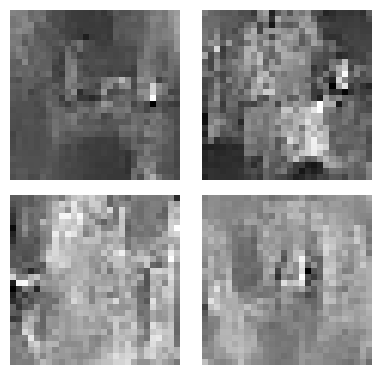

Epoch 6/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 5 = 0.188968
-----------------------------------------------
loss improved from 0.188968 to 0.188968
-----------------------------------------------


Epoch 7/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 6 = 0.183858
-----------------------------------------------
loss improved from 0.183858 to 0.183858
-----------------------------------------------


Epoch 8/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 7 = 0.177147
-----------------------------------------------
loss improved from 0.177147 to 0.177147
-----------------------------------------------


Epoch 9/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 8 = 0.174214
-----------------------------------------------
loss improved from 0.174214 to 0.174214
-----------------------------------------------


Epoch 10/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 9 = 0.170125
-----------------------------------------------
loss improved from 0.170125 to 0.170125
-----------------------------------------------
sample images


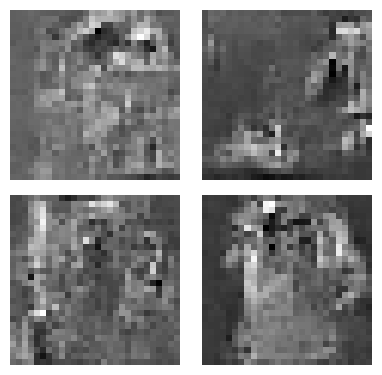

Epoch 11/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 10 = 0.167772
-----------------------------------------------
loss improved from 0.167772 to 0.167772
-----------------------------------------------


Epoch 12/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 11 = 0.165308
-----------------------------------------------
loss improved from 0.165308 to 0.165308
-----------------------------------------------


Epoch 13/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 12 = 0.163030
-----------------------------------------------
loss improved from 0.163030 to 0.163030
-----------------------------------------------


Epoch 14/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 13 = 0.160714
-----------------------------------------------
loss improved from 0.160714 to 0.160714
-----------------------------------------------


Epoch 15/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 14 = 0.156963
-----------------------------------------------
loss improved from 0.156963 to 0.156963
-----------------------------------------------
sample images


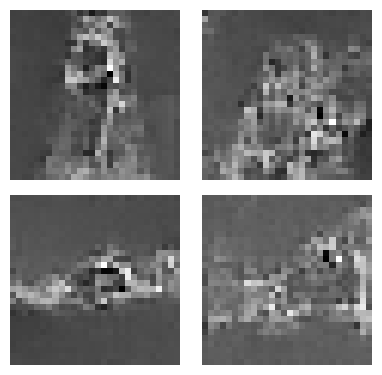

Epoch 16/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 15 = 0.155774
-----------------------------------------------
loss improved from 0.155774 to 0.155774
-----------------------------------------------


Epoch 17/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 16 = 0.154058
-----------------------------------------------
loss improved from 0.154058 to 0.154058
-----------------------------------------------


Epoch 18/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 17 = 0.152466
-----------------------------------------------
loss improved from 0.152466 to 0.152466
-----------------------------------------------


Epoch 19/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 18 = 0.151060
-----------------------------------------------
loss improved from 0.151060 to 0.151060
-----------------------------------------------


Epoch 20/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 19 = 0.148943
-----------------------------------------------
loss improved from 0.148943 to 0.148943
-----------------------------------------------
sample images


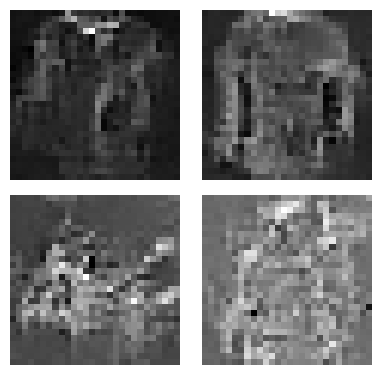

Epoch 21/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 20 = 0.147382
-----------------------------------------------
loss improved from 0.147382 to 0.147382
-----------------------------------------------


Epoch 22/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 21 = 0.147305
-----------------------------------------------
loss improved from 0.147305 to 0.147305
-----------------------------------------------


Epoch 23/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 22 = 0.145744
-----------------------------------------------
loss improved from 0.145744 to 0.145744
-----------------------------------------------


Epoch 24/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 23 = 0.144485
-----------------------------------------------
loss improved from 0.144485 to 0.144485
-----------------------------------------------


Epoch 25/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 24 = 0.143681
-----------------------------------------------
loss improved from 0.143681 to 0.143681
-----------------------------------------------
sample images


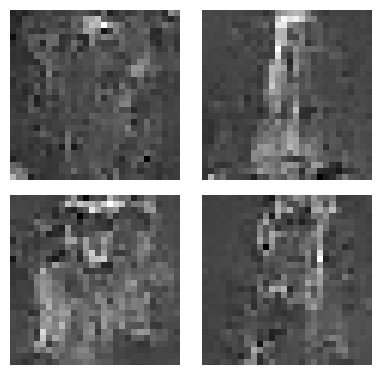

Epoch 26/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 25 = 0.142020
-----------------------------------------------
loss improved from 0.142020 to 0.142020
-----------------------------------------------


Epoch 27/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 26 = 0.142176


Epoch 28/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 27 = 0.140308
-----------------------------------------------
loss improved from 0.140308 to 0.140308
-----------------------------------------------


Epoch 29/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 28 = 0.140494


Epoch 30/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 29 = 0.138463
-----------------------------------------------
loss improved from 0.138463 to 0.138463
-----------------------------------------------
sample images


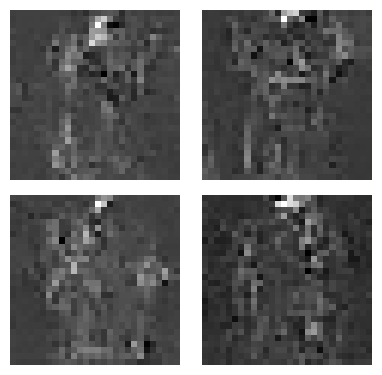

Epoch 31/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 30 = 0.138107
-----------------------------------------------
loss improved from 0.138107 to 0.138107
-----------------------------------------------


Epoch 32/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 31 = 0.137760
-----------------------------------------------
loss improved from 0.137760 to 0.137760
-----------------------------------------------


Epoch 33/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 32 = 0.137299
-----------------------------------------------
loss improved from 0.137299 to 0.137299
-----------------------------------------------


Epoch 34/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 33 = 0.136572
-----------------------------------------------
loss improved from 0.136572 to 0.136572
-----------------------------------------------


Epoch 35/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 34 = 0.136874
sample images


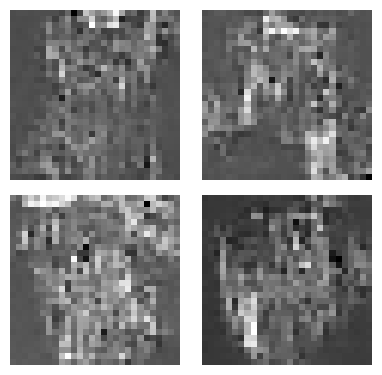

Epoch 36/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 35 = 0.135445
-----------------------------------------------
loss improved from 0.135445 to 0.135445
-----------------------------------------------


Epoch 37/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 36 = 0.135466


Epoch 38/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 37 = 0.134988
-----------------------------------------------
loss improved from 0.134988 to 0.134988
-----------------------------------------------


Epoch 39/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 38 = 0.134567
-----------------------------------------------
loss improved from 0.134567 to 0.134567
-----------------------------------------------


Epoch 40/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 39 = 0.133114
-----------------------------------------------
loss improved from 0.133114 to 0.133114
-----------------------------------------------
sample images


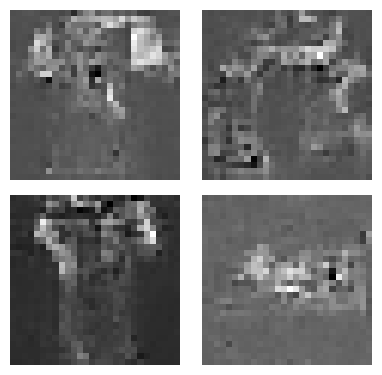

Epoch 41/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 40 = 0.133817


Epoch 42/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 41 = 0.133076
-----------------------------------------------
loss improved from 0.133076 to 0.133076
-----------------------------------------------


Epoch 43/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 42 = 0.133723


Epoch 44/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 43 = 0.132032
-----------------------------------------------
loss improved from 0.132032 to 0.132032
-----------------------------------------------


Epoch 45/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 44 = 0.131739
-----------------------------------------------
loss improved from 0.131739 to 0.131739
-----------------------------------------------
sample images


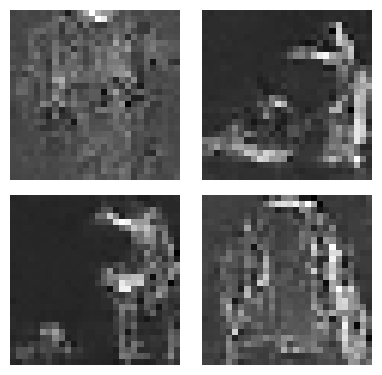

Epoch 46/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 45 = 0.131696
-----------------------------------------------
loss improved from 0.131696 to 0.131696
-----------------------------------------------


Epoch 47/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 46 = 0.130466
-----------------------------------------------
loss improved from 0.130466 to 0.130466
-----------------------------------------------


Epoch 48/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 47 = 0.130918


Epoch 49/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 48 = 0.131195


Epoch 50/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 49 = 0.130215
-----------------------------------------------
loss improved from 0.130215 to 0.130215
-----------------------------------------------
sample images


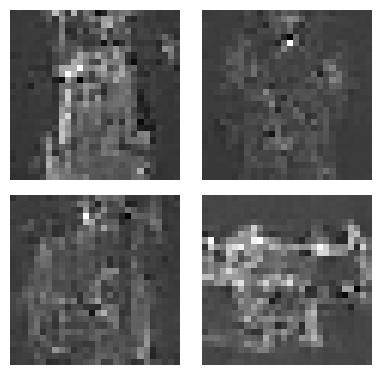

Epoch 51/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 50 = 0.130187
-----------------------------------------------
loss improved from 0.130187 to 0.130187
-----------------------------------------------


Epoch 52/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 51 = 0.129608
-----------------------------------------------
loss improved from 0.129608 to 0.129608
-----------------------------------------------


Epoch 53/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 52 = 0.129996


Epoch 54/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 53 = 0.129463
-----------------------------------------------
loss improved from 0.129463 to 0.129463
-----------------------------------------------


Epoch 55/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 54 = 0.129869
sample images


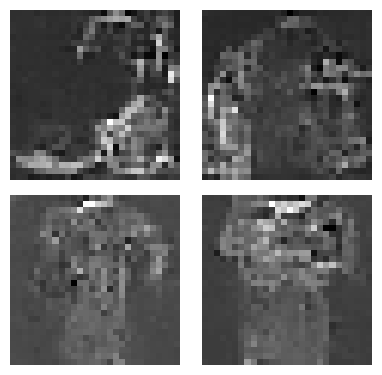

Epoch 56/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 55 = 0.128787
-----------------------------------------------
loss improved from 0.128787 to 0.128787
-----------------------------------------------


Epoch 57/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 56 = 0.129169


Epoch 58/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 57 = 0.127963
-----------------------------------------------
loss improved from 0.127963 to 0.127963
-----------------------------------------------


Epoch 59/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 58 = 0.127160
-----------------------------------------------
loss improved from 0.127160 to 0.127160
-----------------------------------------------


Epoch 60/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 59 = 0.127979
sample images


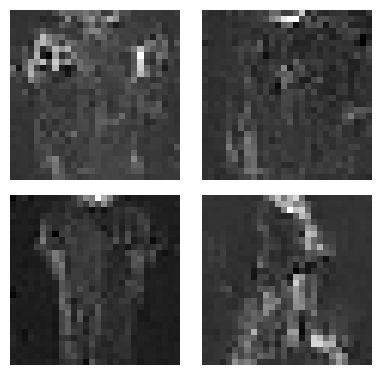

Epoch 61/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 60 = 0.128263


Epoch 62/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 61 = 0.126334
-----------------------------------------------
loss improved from 0.126334 to 0.126334
-----------------------------------------------


Epoch 63/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 62 = 0.126961


Epoch 64/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 63 = 0.125676
-----------------------------------------------
loss improved from 0.125676 to 0.125676
-----------------------------------------------


Epoch 65/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 64 = 0.126739
sample images


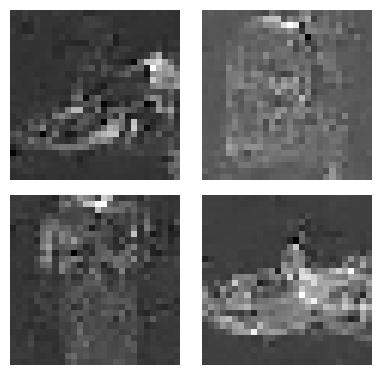

Epoch 66/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 65 = 0.126050


Epoch 67/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 66 = 0.126951


Epoch 68/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 67 = 0.126205


Epoch 69/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 68 = 0.125252
-----------------------------------------------
loss improved from 0.125252 to 0.125252
-----------------------------------------------


Epoch 70/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 69 = 0.126109
sample images


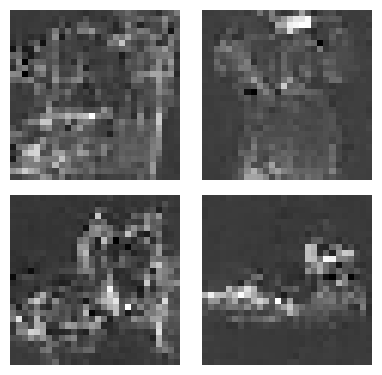

Epoch 71/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 70 = 0.125267


Epoch 72/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 71 = 0.125309


Epoch 73/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 72 = 0.125657


Epoch 74/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 73 = 0.125664


Epoch 75/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 74 = 0.125115
-----------------------------------------------
loss improved from 0.125115 to 0.125115
-----------------------------------------------
sample images


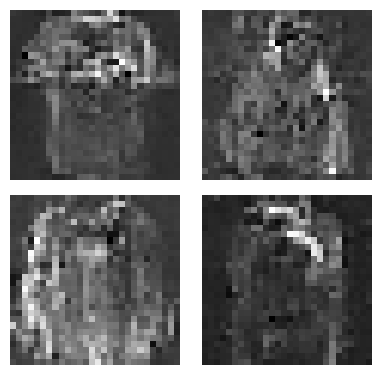

Epoch 76/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 75 = 0.124845
-----------------------------------------------
loss improved from 0.124845 to 0.124845
-----------------------------------------------


Epoch 77/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 76 = 0.125474


Epoch 78/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 77 = 0.125025


Epoch 79/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 78 = 0.123306
-----------------------------------------------
loss improved from 0.123306 to 0.123306
-----------------------------------------------


Epoch 80/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 79 = 0.124556
sample images


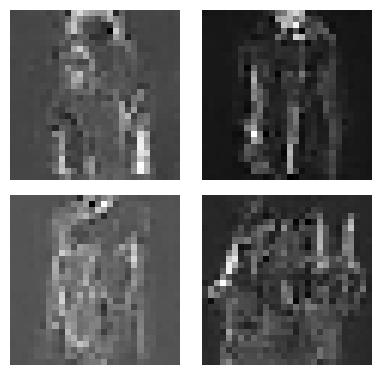

Epoch 81/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 80 = 0.124451


Epoch 82/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 81 = 0.123824


Epoch 83/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 82 = 0.124319


Epoch 84/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 83 = 0.124483


Epoch 85/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 84 = 0.122631
-----------------------------------------------
loss improved from 0.122631 to 0.122631
-----------------------------------------------
sample images


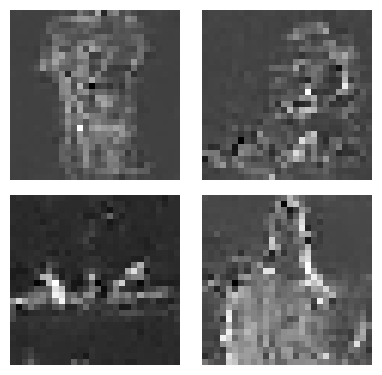

Epoch 86/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 85 = 0.124241


Epoch 87/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 86 = 0.123300


Epoch 88/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 87 = 0.123597


Epoch 89/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 88 = 0.122303
-----------------------------------------------
loss improved from 0.122303 to 0.122303
-----------------------------------------------


Epoch 90/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 89 = 0.123389
sample images


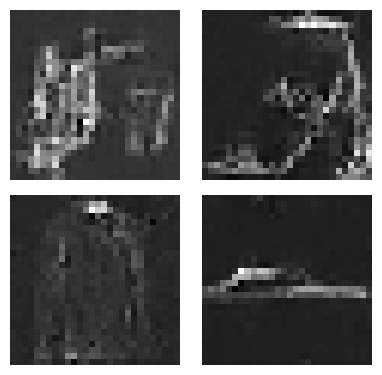

Epoch 91/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 90 = 0.122798


Epoch 92/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 91 = 0.122804


Epoch 93/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 92 = 0.123189


Epoch 94/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 93 = 0.122131
-----------------------------------------------
loss improved from 0.122131 to 0.122131
-----------------------------------------------


Epoch 95/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 94 = 0.122304
sample images


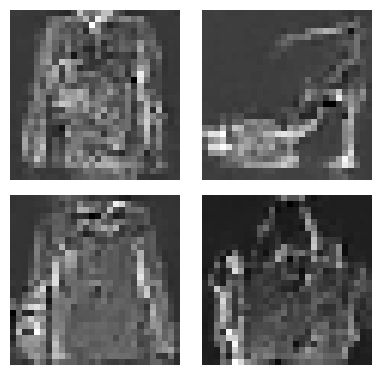

Epoch 96/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 95 = 0.122283


Epoch 97/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 96 = 0.122407


Epoch 98/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 97 = 0.121967
-----------------------------------------------
loss improved from 0.121967 to 0.121967
-----------------------------------------------


Epoch 99/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 98 = 0.120844
-----------------------------------------------
loss improved from 0.120844 to 0.120844
-----------------------------------------------


Epoch 100/100:   0%|          | 0/59 [00:00<?, ?it/s]

Loss at epoch 99 = 0.121524
sample images


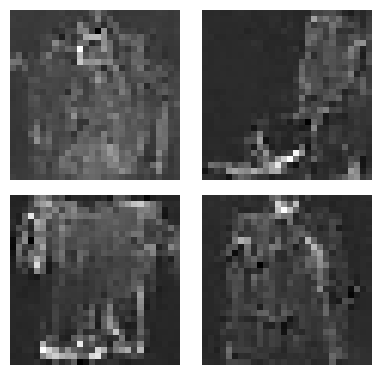

In [50]:
#* load best models and last optimizer
try : 
    Markoddpm.load_state_dict(torch.load(model_path, map_location=torch.device(DEVICE)))
    optimizer.load_state_dict(torch.load(optimizer_path, map_location=torch.device(DEVICE)))
except: 
    print('No models found, training from scratch')

for epoch in tqdm(range(EPOCHS),desc=f"training process",colour="#00AA45",leave='notebook'):
    epoch_loss = 0.0
    for step, (X, _) in enumerate(tqdm(loader, leave=False, desc=f"Epoch {epoch + 1}/{EPOCHS}", colour="#005500")):
        
        #* load data
        X0 = X.to(DEVICE)
        n = len(X0)
        
        #* generate noise and time embedding
        eta = torch.randn_like(X0).to(DEVICE) #* noise with same shape as X0
        t = torch.randint(0, n_step, (n,), device=DEVICE).long() #* time embedding
        
        #* forward pass -> diffuse the noise into the image
        noisy_imgs = Markoddpm(X0, t, eta)
        
        #* predict the noise
        #eta_hat = Markoddpm.backward(noisy_imgs, t) #* reshaping doesn't really matter
        eta_hat = Markoddpm.backward(noisy_imgs, t.reshape(n, 1))
        
        
        #* Optimizing the mse loss, between between 
            #* the predicted noise and the generated noise
            #* eta_hat and eta
        loss = mse(eta_hat, eta)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item() * len(X0) / len(loader.dataset) 
    
    log_string = f"Loss at epoch {epoch} = {epoch_loss:.6f}"
    print(log_string)
    #* saving the model
    
    if epoch_loss < BEST_LOSS:
        BEST_LOSS = epoch_loss
        torch.save(Markoddpm.state_dict(), model_path)
        torch.save(optimizer.state_dict(), optimizer_path)
        print("-----------------------------------------------")
        print(f"loss improved from {BEST_LOSS:.6f} to {epoch_loss:.6f}")
        log_string += ": model and optimizer saved"
        # print(log_string)
        print("-----------------------------------------------")
        
    if (epoch+1) % 5 == 0:
        
        with torch.no_grad():
            print("sample images")
            show_images(generate_new_images(
                Markoddpm,
                n_sample=4,
                device=DEVICE,
                gif_name = gif_path  + f"DDPM after epoch {epoch+1}.gif")
            )


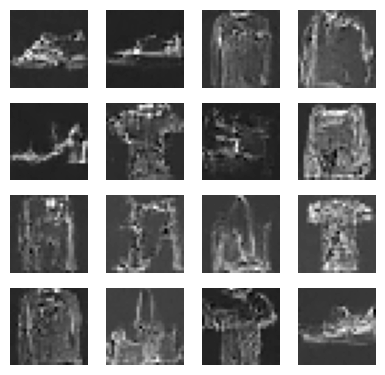

In [54]:
Markoddpm.load_state_dict(torch.load(model_path, map_location=torch.device(DEVICE)))
optimizer.load_state_dict(torch.load(optimizer_path, map_location=torch.device(DEVICE)))

show_images(
    generate_new_images(
        Markoddpm, n_sample=16, device=DEVICE, gif_name="best_model_sampling.gif"
    )
)